# Analysis of Output from Hybrid Approach

In [1]:
# Import the Pandas library
import pandas as pd

# Read in the output data
df = pd.read_csv('../output/output_df.csv',encoding='utf-8',quotechar='"')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13491 entries, 0 to 13490
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   author                       13491 non-null  object 
 1   deterministic_author         4339 non-null   object 
 2   fuzzy_author                 5321 non-null   object 
 3   fuzzy_author_score           13491 non-null  float64
 4   distilbert_author            13491 non-null  object 
 5   distilbert_author_score      13491 non-null  float64
 6   title                        13491 non-null  object 
 7   matched_title_deterministic  13491 non-null  object 
 8   matched_title_fuzzy          13491 non-null  object 
 9   fuzzy_title_score            13491 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.0+ MB


## First impressions

Just looking at the output of the `info()` method, I see that there are 13,491 total rows in the dataframe. That's down from over 20,000 in the original, thanks to the deduplication I was able to do in the `prepare_hathi.ipynb` notebook. 

Some of the columns do not have data in all of the rows. Specifically, `deterministic_author` and `fuzzy_author` have empty cells. That suggests that the deterministic method is the most "conservative" approach, and it looks like the fuzzy matching approach comes in second in that regard.

In [2]:
df.describe()

,fuzzy_author_score,distilbert_author_score,fuzzy_title_score
count,13491.000000,13491.000000,13491.000000
mean,0.391364,0.790084,0.151044
std,0.485130,0.298975,0.326466
min,0.000000,0.082294,0.000000
25%,0.000000,0.568069,0.000000
50%,0.000000,0.999766,0.000000
75%,1.000000,0.999998,0.000000
max,1.000000,1.000000,0.900000


The `describe()` method only covers two author matching methods, but it tells its own story. In previous analyses, the fuzzy matching method appeared to be slightly more liberal, with a 86.04% matching average, while the DistilBERT model had an 82.29% average. Now, with fewer records to begin with, the mean fuzzy author score is much lower: 41.6%. The mean distilbert matching score is also lower, by a little: 79%.

More revealing is the quartile output. The fuzzy matching method has nothing until the 75th percentile, when it reports 100% matching. That's a big change from previous attempts, when 25% of the records registered an 85.5% match from the fuzzy method, and the DistilBERT model returned 68.9% at that level. No the DistilBERT method achieved only 56.8% at the 25th percentile, but it rose dramatically at the 50th percentile, to 99.97%.

I attribute the difference to the fact that I raised the cutoff values for the fuzzy matching and DistilBERT methods.

In [3]:
df.head()

,author,deterministic_author,fuzzy_author,fuzzy_author_score,distilbert_author,distilbert_author_score,title,matched_title_deterministic,matched_title_fuzzy,fuzzy_title_score
0,"Du Creux, François, 1596?-1666.",NaN,NaN,0.0,"{'authorized_name': 'cruz, luís da, 1543-1604...",0.467436,"Historiæ canadensis, seu Novæ-Franciæ libri de...",Unknown,Unknown,0.0
1,"Meyer, Ernst H. F. 1791-1858.",NaN,NaN,0.0,"{'authorized_name': 'meyer, wilhelm, 1845-1917...",0.999939,Ernesti Meyer de plantis labradoricis libri tres.,Unknown,Unknown,0.0
2,"Laet, Joannes de, 1593-1649.",NaN,NaN,0.0,"{'authorized_name': 'larroumet, gustave', 'aut...",0.494394,"Novus orbis, seu Descriptionis Indiae Occident...",Unknown,Unknown,0.0
3,"Caesar, Julius",NaN,"{'authorized_name': 'caesar, julius', 'author_...",1.0,"{'authorized_name': 'caesar, julius', 'author_...",0.999999,C. Julii Cæsaris commentariorum De Bello Galli...,Unknown,Unknown,0.0
4,Unknown,NaN,NaN,0.0,{'authorized_name': 'stephanus abbas 4. or 6th...,0.177454,Collectanea latina seu ecclesiasticæ antiquita...,Unknown,Unknown,0.0


In [4]:
# Get the number of unique values in the `author` column
df['author'].nunique()

5556

That number hasn't changed from previous analyses, so we'll still see how well the different methods performed on authors unknown to them.

Note that this does not mean that there are 5,556 unique authors in the dataframe. Rather, there are 5,556 unique name forms. For example, "Virgil", "Virgil,", "Virgil." (note the punctuation marks in the last two), "Virgile (0070-0019 av. J.-C.).", and "Virgilio Marón, Publio" all refer to the same person.

## Deterministic Author Matching

I want to see where this method reported a match.

In [5]:
# Make a dataframe of just the author and deterministic author columns
deterministic = df[['author','deterministic_author']]
# Filter out the NA values
deterministic = deterministic[deterministic['deterministic_author'].notna()]
deterministic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 6 to 13488
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   author                4339 non-null   object
 1   deterministic_author  4339 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


In [6]:
# Count the number of unique values in the deterministic_author column
print(f"There are {deterministic['deterministic_author'].nunique()} unique authors in the deterministic dataframe.")

There are 444 unique authors in the deterministic dataframe.


There are 444 unique values in the `deterministic_author` column. That's the same number that I found in `analysis-2.ipynb`, which was twelve more than in `analysis.ipynb`.

I'm going to make a CSV file so that I can investigate the matches more easily. I'll sort the `deterministic` dataframe by the `author` column first, then save the sorted dataframe as a CSV file.

In [7]:
sorted_deterministic = deterministic.sort_values(axis='index',by='author')
sorted_deterministic_deduped = sorted_deterministic.drop_duplicates(subset='author')

In [8]:
import csv
sorted_deterministic_deduped.to_csv('../output/deterministic_author.csv',index=False,quoting=csv.QUOTE_ALL)

As expected, every match achieved by the deterministic method was 100% accurate. On the other hand, it matched only 444 of the 5,556 unique values in the `author` column, or about 8%. But that doesn't mean that there are 5,112 unmatched individual authors. Rather, there are 5,112 unmatched author name forms. Unfortunately, we won't know how many unique authors those 5,112 unmatched name forms belong to. We won't know that until we've successfully matched as many of them as possible with their authorized name forms.

Just for the sake of having the information, I'll inspect the author name forms that were deterministically matched. Since the `deterministic_author` column has dictionary values (e.g, `{'authorized_name': 'virgil', 'author_id': 'A4830'}`), I'll need to process the column by retrieving just the authorized name form.

In [9]:
import ast
sorted_deterministic_deduped.loc[:,'deterministic_author_name'] = sorted_deterministic_deduped['deterministic_author'].apply(lambda x: ast.literal_eval(x)['authorized_name'] if isinstance(x, str) else x['authorized_name'])

/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_58675/2177542474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_deterministic_deduped.loc[:,'deterministic_author_name'] = sorted_deterministic_deduped['deterministic_author'].apply(lambda x: ast.literal_eval(x)['authorized_name'] if isinstance(x, str) else x['authorized_name'])


In [10]:
for author in sorted_deterministic_deduped['deterministic_author_name'].unique():
    print(author)

abbo, monk of st. germain, approximately 850-approximately 923
abelard, peter
acosta, josé de, 1540-1600
agricola, georg, 1494-1555
agricola, rodolphus, 1443?-1485
agrippa von nettesheim, heinrich cornelius, 1486?-1535
agustín, antonio, 1517-1586
ailly, pierre d', 1350-1420
alanus, de insulis
alberti, leon battista, 1404-1472
albertus, magnus, saint, 1193?-1280
albertus, de saxonia, -1390
alciati, andrea, 1492-1550
aldhelm, saint
aldrovandi, ulisse, 1522-1605?
alexander, of hales, approximately 1185-1245
alexander, de villa dei
alfred, of sareshel
alvares, manuel, 1526-1583
ambrose, saint, bishop of milan
amelli, ambrogio, 1848-1933
ammianus marcellinus
ampelius, lucius
andreas, capellanus
andreä, johann valentin, 1586-1654
angèli, pietro, 1517-1596
anselm, saint, archbishop of canterbury
antonius, marcus, 83 b.c.?-30 b.c.
apponius
arator, subdiaconus
arnobius, of sicca
astruc, jean, 1684-1766
augurelli, giovanni aurelio, approximately 1456-1524?
augustine, of hippo, saint, 354-430

It's quite a mix of Classical, Medieval, and Neo-Latin authors!

I'll remove these authors from the analysis of results from the fuzzy matching and DistilBERT matching, since they can be considered 100% matched.

In [204]:
# Use a list comprehension with the unique() method to make a list of deterministically matched authors.
deterministically_matched_authors_list = [author for author in sorted_deterministic_deduped['deterministic_author_name'].unique()]

## Fuzzy Author Matching

In [12]:
# Make a dataframe of the fuzzy matching columns and the author column
fuzzy = df[['author','fuzzy_author','fuzzy_author_score']]
# Eliminate any NaN cells
fuzzy = fuzzy[fuzzy['fuzzy_author'].notna()]
fuzzy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5321 entries, 3 to 13488
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   author              5321 non-null   object 
 1   fuzzy_author        5321 non-null   object 
 2   fuzzy_author_score  5321 non-null   float64
dtypes: float64(1), object(2)
memory usage: 166.3+ KB


In [13]:
# Count the number of unique values in the fuzzy_author column
fuzzy['fuzzy_author'].nunique()

518

The fuzzy matching method returned 555 unique values (down from 1,081 in `analysis.ipynb`, but up from 551 in `analysis-2.ipynb`), compared to the 5,556 unique values in the `author` column.

I'll remove the authors that we already know were deterministically matched so that we can examine what value, if any, the fuzzy matching algorithm added. To do that I need to get the `authorized_name` value from the dictionary in the `fuzzy_author` column.

In [219]:
# Get the authorized name values
fuzzy.loc[:,'fuzzy_author_name'] = fuzzy['fuzzy_author'].apply(lambda x: ast.literal_eval(x)['authorized_name'] if isinstance(x, str) else x['authorized_name'])
# Remove the deterministically matched authors
fuzzy_not_deterministic = fuzzy[~fuzzy['fuzzy_author_name'].isin(deterministically_matched_authors)]
fuzzy_not_deterministic.info()
fuzzy_matched_authors_list = [utilities.normalize_author_name(author) for author in fuzzy_not_deterministic['author'].unique()]
fuzzy_matched_authors_list

<class 'pandas.core.frame.DataFrame'>
Index: 355 entries, 29 to 13482
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   author              355 non-null    object 
 1   fuzzy_author        355 non-null    object 
 2   fuzzy_author_score  355 non-null    float64
 3   fuzzy_author_name   355 non-null    object 
dtypes: float64(1), object(3)
memory usage: 13.9+ KB


['vitruvius pollio',
 'palladius rutilius taurus aemilianus',
 'gellius aulus',
 'quintilian',
 'ordericus vitalis 10751143',
 'justinus marcus junianus',
 'madvig j n 18041886',
 'vitruvius pollio',
 'quintilian',
 'varro marcus terentius',
 'sedulius scotus active 848860',
 'gellius aulus',
 'more thomas sir saint 14781535',
 'biondo flavio 13921463',
 'salvian of marseilles approximately 400approximately 480',
 'giraldus cambrensis 11461223',
 'sannazaro jacopo 14581530',
 'agobard saint 769840',
 'corippus flavius cresconius',
 'scaliger joseph juste 15401609',
 'john of salisbury bishop of chartres 1180',
 'boniface saint archbishop of mainz approximately 675754',
 'melanchthon philipp 14971560',
 'walahfrid strabo 807849',
 'justinus marcus junianus',
 'dinter bernhard 1825',
 'pohlenz m 18721962',
 'plautus titus maccius',
 'larroumet gustave 18521902',
 'varro marcus terentius',
 'wagner johann augustin',
 'hildegard saint 10981179',
 'sedulius scotus active 848860',
 'lotichiu

That removed all but 355 entries, compared to 527 in `analysis-3.ipynb`!

Now let's see which authors weren't matched at all.

In [15]:
unmatched_fuzzy = df[df['fuzzy_author'].isna()]
# Show the number of unique author values in the unmatched_fuzzy dataframe
display(unmatched_fuzzy['author'].nunique())
# Display the list of unmatched author names
unmatched_authors_list = [author for author in sorted(unmatched_fuzzy['author'].unique())]
for author in unmatched_authors_list:
    print(author)


4634

Abad, Diego José, 1727-1779
Abadía de Santillana del Mar.
Abati, Baldo Angelo
Abaunza, Pedro de 1599-1649.
Abbatius, Baldus Angelus, 16th cent.
Abbeloos, J. B. 1836-1896.
Abbeloos, Jean Baptiste, 1836-1906.
Abicht, Rudolf, 1850-1921.
Abrahams, Nicolai Christian Levin, 1798-1870.
Abril, Pedro Simón, ca. 1530- ca. 1595.
Abu al-Faraj al-Isbahani, 897 or 8-967.
Abū Miḥjan al-Thaqafī, active 629-637
Abū Tammām Ḥabīb ibn Aws al-Ṭāʼī, active 808-842
Abū Tammām Ḥabīb ibn Aws al-Ṭāʾī, fl. 808-842,
Abū al-Rabīʻ Sulaymān ibn ʻAbd Allāh al-Muwaḥḥid.
Abū ʻUbayd al-Qāsim ibn Sallām, approximately 773-approximately 837
Abū al-Faraj al-Iṣbahānī, 897 or 898-967.
Academia Molshemensis (Francia)
Accademia degli Occulti (Brescia)
Acevedo, Alfonso de, 1518-1598
Achillini, Alessandro
Achillini, Alessandro, 1463-1512.
Acidalius, Valens, 1567-1595
Ackermann, Johann Christian Gottlieb, 1756-1801
Ackermann, Petrus Fouerius, 1771-1831
Aconcio, Iacopo, -1566.
Actuarius, Johannes.
Adam, 

A lot of the authors in that list do not look familiar to me, so it is likely that they simply do not yet have records in the DLL's catalog. On the other hand, some of the names *should have been matched*. For example, "Catulo, Cayo Valerio" and "Catón, Marco Porcio (Mayor)" probably should have been matched, but the spellings are sufficiently different that they were not. It is better to be conservative!

How many authors were matched by fuzzy matching that were not matched by the deterministic method?

In [190]:
print(f"Number of unique authors matched by deterministic and fuzzy matching combined: {len(deterministically_matched_authors_list)+len(fuzzy_not_deterministic)}")

Number of unique authors matched by deterministic and fuzzy matching combined: 799


## DistilBERT Matching

In [16]:
distilbert_model = df[['author','distilbert_author','distilbert_author_score']].reset_index()
# Eliminate any NaN cells
distilbert_model = distilbert_model[distilbert_model['distilbert_author'].notna()]

distilbert_model.info()

# Count the number of unique values in the fuzzy_author column
print(f"There are {distilbert_model['distilbert_author'].nunique()} unique values in the distilbert_model frame.")
print(f"That is {distilbert_model['distilbert_author'].nunique()-fuzzy_not_deterministic['fuzzy_author'].nunique()} more than in the fuzzy frame.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13491 entries, 0 to 13490
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    13491 non-null  int64  
 1   author                   13491 non-null  object 
 2   distilbert_author        13491 non-null  object 
 3   distilbert_author_score  13491 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 421.7+ KB
There are 1891 unique values in the distilbert_model frame.
That is 1817 more than in the fuzzy frame.


That's without removing the deterministically matched authors.

In [17]:
# Get the authorized name values
distilbert_model.loc[:,'distilbert_author_name'] = distilbert_model['distilbert_author'].apply(lambda x: ast.literal_eval(x)['authorized_name'] if isinstance(x, str) else x['authorized_name'])
# Remove the deterministically matched authors
distilbert_model = distilbert_model[~distilbert_model['distilbert_author_name'].isin(deterministically_matched_authors_list)]
distilbert_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6729 entries, 0 to 13490
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    6729 non-null   int64  
 1   author                   6729 non-null   object 
 2   distilbert_author        6729 non-null   object 
 3   distilbert_author_score  6729 non-null   float64
 4   distilbert_author_name   6729 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 315.4+ KB


That removed 6,761 rows, leaving 6,729 rows.

In [194]:
# Count the number of unique values in the fuzzy_author column
print(f"There are {distilbert_model['distilbert_author'].nunique()} unique values in the distilbert_model frame.")
print(f"That is {distilbert_model['distilbert_author'].nunique()-fuzzy_not_deterministic['fuzzy_author'].nunique()} more than in the fuzzy frame.")

There are 1448 unique values in the distilbert_model frame.
That is 1374 more than in the fuzzy frame.


The DistilBERT model identified a match for all authors it encountered, which almost certainly means that there are many incorrect matches.

I want to look at the metrics for the DistilBERT and Fuzzy Matching methods. I'll make a set of ranges from 75% to 100% confidence and count up the numbers in each range per method.

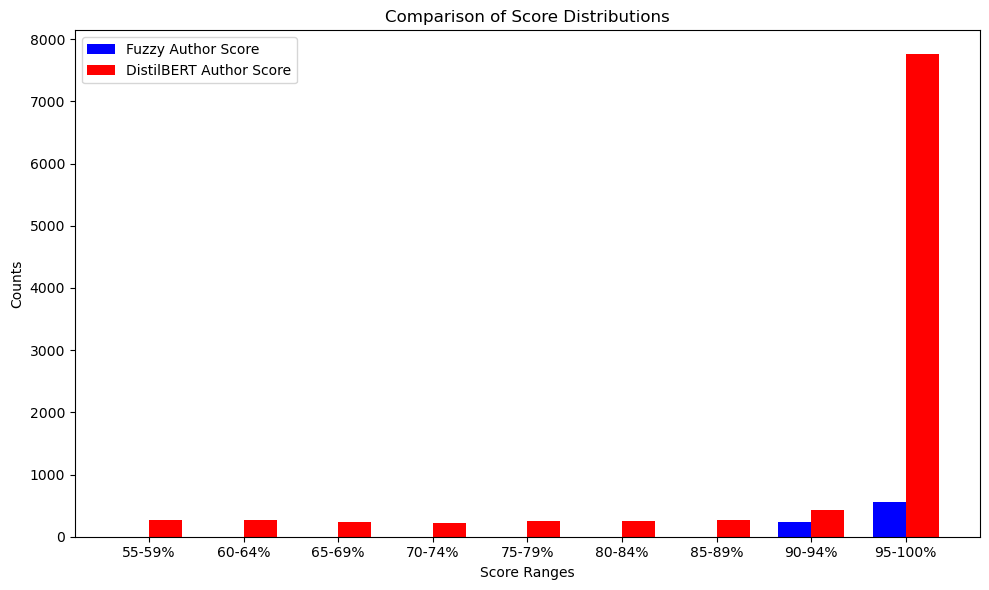

In [22]:
# Visualize the differences
import matplotlib.pyplot as plt
import numpy as np  # Ensure this import is present for array operations

# Assuming 'df' is your original DataFrame with the metrics
bins = [54, 59, 64, 69, 74, 79, 84, 89, 94, 100]
labels = ['55-59%', '60-64%', '65-69%', '70-74%', '75-79%', '80-84%', '85-89%', '90-94%', '95-100%']

metrics = df.copy()
metrics['distilbert_author_score'] = (metrics['distilbert_author_score'] * 100).astype(int)
metrics['fuzzy_author_score'] = (metrics['fuzzy_author_score'] * 100).astype(int)

# Initialize an empty DataFrame with labels as index
comparison_df = pd.DataFrame(index=labels)

# Apply pd.cut and calculate value counts, then add to comparison_df
for metric in ['fuzzy_author_score', 'distilbert_author_score']:
    metrics[f'{metric}_range'] = pd.cut(metrics[metric], bins=bins, labels=labels, right=False)
    comparison_df[metric] = metrics[f'{metric}_range'].value_counts().reindex(labels, fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(labels))

bar1 = plt.bar(index, comparison_df['fuzzy_author_score'], bar_width, label='Fuzzy Author Score', color='blue')
bar2 = plt.bar(index + bar_width, comparison_df['distilbert_author_score'], bar_width, label='DistilBERT Author Score', color='red')

plt.xlabel('Score Ranges')
plt.ylabel('Counts')
plt.title('Comparison of Score Distributions')
plt.xticks(index + bar_width / 2, labels)
plt.legend()

plt.tight_layout()
plt.show()

That really shows how greedy the DistilBERT model is about matching. It's very confident about the vast majority of the matches it performed, but the fuzzy matching algorithm was far more conservative.

I will take a closer look at the DistilBERT model's matches.

In [38]:
db_90_100 = metrics[(metrics['distilbert_author_score_range'] == "95-100%") | (metrics['distilbert_author_score_range'] == "90-94%")]
db_90_100 = db_90_100[['author','distilbert_author']]
grouped = db_90_100.groupby(['author','distilbert_author']).value_counts().to_frame().reset_index()
grouped.to_csv('../output/grouped_distilbert_author_matches_90_100.csv',index=False,encoding='utf-8',quoting=csv.QUOTE_ALL)
display(db_90_100)

,author,distilbert_author
1,"Meyer, Ernst H. F. 1791-1858.","{'authorized_name': 'meyer, wilhelm, 1845-1917..."
3,"Caesar, Julius","{'authorized_name': 'caesar, julius', 'author_..."
5,"Drexel, Jeremias, 1581-1638,",{'authorized_name': 'drepanius florus 5th cent...
6,"Kircher, Athanasius, 1602-1680","{'authorized_name': 'kircher, athanasius, 1602..."
7,"Hincmar, Archbishop of Reims, approximately 80...","{'authorized_name': 'hincmar, archbishop of re..."
...,...,...
13477,"Lucan, 39-65.","{'authorized_name': 'lucan', 'author_id': 'A50..."
13478,"Petermann, August, 1818-","{'authorized_name': 'peter, hermann, 1837-1914..."
13481,"Linné, Carl von, 1707-1778","{'authorized_name': 'linné, carl von, 1707-17..."
13482,"Epiphanius, Saint, Bishop of Constantia in Cyp...","{'authorized_name': 'epiphanius, saint, bishop..."


In [39]:
# Use the `normalize_author_name()` utility function to lower the `author` value and remove punctuation.
import utilities as utilities
db_90_100['stripped_author'] = db_90_100['author'].apply(lambda x: utilities.normalize_author_name(x))

import ast
db_90_100['distil_author_only'] = db_90_100['distilbert_author'].apply(lambda x: ast.literal_eval(x)['authorized_name'] if isinstance(x, str) else x['authorized_name'])
db_90_100['distil_author_only'] = db_90_100['distil_author_only'].apply(lambda x: utilities.normalize_author_name(x))
# Make a dataframe of the stripped_author and distil_author_only columns
db_90_100 = db_90_100[['stripped_author','distil_author_only']]

# Now get just the unique authors from that dataframe
unique_authors = db_90_100.drop_duplicates(subset=['stripped_author','distil_author_only'])
display(unique_authors)

,stripped_author,distil_author_only
1,meyer ernst h f 17911858,meyer wilhelm 18451917
3,caesar julius,caesar julius
5,drexel jeremias 15811638,drepanius florus 5th century
6,kircher athanasius 16021680,kircher athanasius 16021680
7,hincmar archbishop of reims approximately 806882,hincmar archbishop of reims
...,...,...
13305,klotz christian adolph 17381771,klotz alfred 18741956
13370,ibn arabshah ahmad ibn muhammad 13921450,avicenna 9801037
13422,schuster ildefonso 18801954,ildephonsus saint
13433,buchanan david 15951652,buchanan george


In [40]:
from rapidfuzz import fuzz, process

unique_authors.loc[:,'partial_token_set'] = [
    fuzz.partial_token_set_ratio(a, b)
    for a, b in zip(unique_authors['stripped_author'], unique_authors['distil_author_only'])
]

unique_authors.loc[:,'token_set'] = [
    fuzz.token_set_ratio(a, b)
    for a, b in zip(unique_authors['stripped_author'], unique_authors['distil_author_only'])
]

unique_authors.loc[:,'token_sort'] = [
    fuzz.token_sort_ratio(a, b)
    for a, b in zip(unique_authors['stripped_author'], unique_authors['distil_author_only'])
]

unique_authors.to_csv('../output/unique_authors_fuzzy_scores.csv',index=False,encoding='utf-8',quoting=csv.QUOTE_ALL)
display(unique_authors)

/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_58675/976594758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_authors.loc[:,'partial_token_set'] = [
/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_58675/976594758.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_authors.loc[:,'token_set'] = [
/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_58675/976594758.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,stripped_author,distil_author_only,partial_token_set,token_set,token_sort
1,meyer ernst h f 17911858,meyer wilhelm 18451917,100.000000,47.826087,39.130435
3,caesar julius,caesar julius,100.000000,100.000000,100.000000
5,drexel jeremias 15811638,drepanius florus 5th century,35.555556,30.769231,30.769231
6,kircher athanasius 16021680,kircher athanasius 16021680,100.000000,100.000000,100.000000
7,hincmar archbishop of reims approximately 806882,hincmar archbishop of reims,100.000000,100.000000,72.000000
...,...,...,...,...,...
13305,klotz christian adolph 17381771,klotz alfred 18741956,100.000000,53.846154,53.846154
13370,ibn arabshah ahmad ibn muhammad 13921450,avicenna 9801037,41.379310,30.769231,32.142857
13422,schuster ildefonso 18801954,ildephonsus saint,58.823529,45.454545,45.454545
13433,buchanan david 15951652,buchanan george,100.000000,69.565217,47.368421


In [41]:
# Add a standard deviation column
unique_authors.loc[:,'std'] = unique_authors.std(axis=1, numeric_only=True)

/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_58675/1173378012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_authors.loc[:,'std'] = unique_authors.std(axis=1, numeric_only=True)


In [42]:
display(unique_authors)

,stripped_author,distil_author_only,partial_token_set,token_set,token_sort,std
1,meyer ernst h f 17911858,meyer wilhelm 18451917,100.000000,47.826087,39.130435,32.921208
3,caesar julius,caesar julius,100.000000,100.000000,100.000000,0.000000
5,drexel jeremias 15811638,drepanius florus 5th century,35.555556,30.769231,30.769231,2.763386
6,kircher athanasius 16021680,kircher athanasius 16021680,100.000000,100.000000,100.000000,0.000000
7,hincmar archbishop of reims approximately 806882,hincmar archbishop of reims,100.000000,100.000000,72.000000,16.165808
...,...,...,...,...,...,...
13305,klotz christian adolph 17381771,klotz alfred 18741956,100.000000,53.846154,53.846154,26.646936
13370,ibn arabshah ahmad ibn muhammad 13921450,avicenna 9801037,41.379310,30.769231,32.142857,5.770221
13422,schuster ildefonso 18801954,ildephonsus saint,58.823529,45.454545,45.454545,7.718586
13433,buchanan david 15951652,buchanan george,100.000000,69.565217,47.368421,26.423023


In [43]:
# Get a report on the standard deviations
bins = [0,1,2,3,4,5,6]
labels = [0,1,2,3,4,5]
# Applying pd.cut and counting values for each metric
for metric in ['std']:
    unique_authors.loc[:,f'{metric}_range'] = pd.cut(unique_authors[metric], bins=bins, labels=labels, right=False)
    print(f"Counts for {metric}:")
    print(unique_authors[f'{metric}_range'].value_counts().sort_index())
    print("\n")

Counts for std:
std_range
0    457
1     93
2     92
3    104
4    119
5    106
Name: count, dtype: int64




/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_58675/2645712410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_authors.loc[:,f'{metric}_range'] = pd.cut(unique_authors[metric], bins=bins, labels=labels, right=False)


The standard deviation for 457 rows is between 0 and 1, which means that the match is very probably correct. It's not great that the numbers are so high from 1 up to 5, but perhaps there is something in there that will help predict which matches are correct.

I'm going to inspect the csv of the unique_authors to see how many are actually correct matches.

In [44]:
unique_authors.to_csv('../output/unique_authors_fuzzy_scores_and_stdev.csv',index=False,encoding='utf-8',quoting=csv.QUOTE_ALL)

I found that 100% of the rows with a standard deviation of 0 were a perfect match. That makes sense, since all three fuzzy algorithms reported a 100% match. That accounts for only 384 of the 2,120 matches, however.

I manually reviewed all 2,120 rows and found little help from the current metrics to help weed out the bad matches. I added a column called `correct` to identify the correct and incorrect matches. I also added columns for the standard deviation between `partial_token_set` and `token_set`, `partial_token_set` and `token_sort`, and `token_set` and `token_sort`. That doesn't appear to have yielded anything significant.

In [116]:
correct_yes_no = pd.read_csv('../output/unique_authors_fuzzy_scores_and_stdev_correct.csv',encoding='utf-8',quotechar='"')
display(correct_yes_no.describe())

,partial_token_set,token_set,token_sort,std,std_partial_ts_token_set,std_partial_ts_token_sort,std_tokenset_token_sort
count,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000
mean,78.958598,64.608121,60.154555,10.596703,10.207086,13.353690,3.162663
std,25.042763,27.135875,25.044436,10.488912,11.949278,13.463450,7.098262
min,25.000000,13.636364,13.636364,0.000000,0.000000,0.000000,0.000000
25%,52.380952,40.909091,40.000000,1.793099,0.000000,2.196089,0.000000
50%,100.000000,57.142857,53.061224,6.932536,5.840072,8.490588,0.000000
75%,100.000000,100.000000,81.754161,17.619296,15.762284,21.938174,1.106995
max,100.000000,100.000000,100.000000,43.072163,51.068823,54.997194,52.752411


In [117]:
correct_yes_no.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stripped_author            2119 non-null   object 
 1   distil_author_only         2119 non-null   object 
 2   correct                    2119 non-null   object 
 3   partial_token_set          2119 non-null   float64
 4   token_set                  2119 non-null   float64
 5   token_sort                 2119 non-null   float64
 6   std                        2119 non-null   float64
 7   std_partial_ts_token_set   2119 non-null   float64
 8   std_partial_ts_token_sort  2119 non-null   float64
 9   std_tokenset_token_sort    2119 non-null   float64
dtypes: float64(7), object(3)
memory usage: 165.7+ KB


This might be sheer madness, but I'm going to throw all of the distance metrics from `rapidfuzz` at the `stripped_author` and `distil_author` columns and look for some sort of meaningful correlation.

In [118]:
from rapidfuzz.distance import DamerauLevenshtein, Hamming, Indel, Jaro, JaroWinkler, Levenshtein, LCSseq, OSA
# Make a list of the distance metrics
distances_list = [DamerauLevenshtein, Hamming, Indel, Jaro, JaroWinkler, Levenshtein, LCSseq, OSA]
# Loop over the distance metrics, making a new column for each one
for distance in distances_list:
    correct_yes_no[str(distance)] = correct_yes_no.apply(lambda x: distance.distance(x['stripped_author'], x['distil_author_only']),axis=1)
# Fix the column names
correct_yes_no = correct_yes_no.rename(columns={"<module 'rapidfuzz.distance.DamerauLevenshtein' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/DamerauLevenshtein.py'>":"DamerauLevenshtein",
                                                "<module 'rapidfuzz.distance.Hamming' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/Hamming.py'>": "Hamming",	
                                                "<module 'rapidfuzz.distance.Indel' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/Indel.py'>": "Indel",	
                                                "<module 'rapidfuzz.distance.Jaro' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/Jaro.py'>": "Jaro",	
                                                "<module 'rapidfuzz.distance.JaroWinkler' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/JaroWinkler.py'>": "JaroWinkler",	
                                                "<module 'rapidfuzz.distance.Levenshtein' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/Levenshtein.py'>": "Levenshtein",	
                                                "<module 'rapidfuzz.distance.LCSseq' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/LCSseq.py'>": "LCSseq",	
                                                "<module 'rapidfuzz.distance.OSA' from '/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/rapidfuzz/distance/OSA.py'>": "OSA"
                                                }
                                        )
display(correct_yes_no)

,stripped_author,distil_author_only,correct,partial_token_set,token_set,token_sort,std,std_partial_ts_token_set,std_partial_ts_token_sort,std_tokenset_token_sort,DamerauLevenshtein,Hamming,Indel,Jaro,JaroWinkler,Levenshtein,LCSseq,OSA
0,godham adam,wodeham adam 1358,maybe,100.000000,71.428571,71.428571,16.495722,20.203051,20.203051,0.000000,7,15,8,0.167558,0.167558,7,7,7
1,cornelius carl,cornelius pope,maybe,100.000000,78.260870,64.285714,17.997245,15.371887,25.253814,9.881927,4,4,8,0.190476,0.114286,4,4,4
2,valeriano bolzani giovan piero 14771558,valeriano pierio 14771560,maybe,100.000000,68.750000,68.750000,18.042196,22.097087,22.097087,0.000000,18,29,20,0.206897,0.124138,18,17,18
3,handel salomon,salomon iii,maybe,100.000000,77.777778,64.000000,18.164316,15.713484,25.455844,9.742360,11,13,11,0.529437,0.529437,11,7,11
4,capreolus johannes,capreolus of carthage,maybe,100.000000,66.666667,66.666667,19.245009,23.570226,23.570226,0.000000,10,11,11,0.208995,0.125397,10,7,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,suetonio tranquilo cayo,suetonius approximately 69approximately 122,yes,58.823529,36.363636,36.363636,12.967225,15.881543,15.881543,0.000000,30,36,38,0.331737,0.331737,30,29,30
2115,burchardus episcopus wormaciensis,burchard bishop of worms,yes,58.333333,56.140351,56.140351,1.266119,1.550673,1.550673,0.000000,15,24,19,0.298578,0.179147,15,14,15
2116,valerio flaco cayo,valerius flaccus gaius,yes,55.555556,55.000000,55.000000,0.320750,0.392837,0.392837,0.000000,9,16,14,0.219096,0.131457,9,9,9
2117,plinius caecilus secundus c,pliny the elder,yes,53.333333,42.857143,42.857143,6.048431,7.407785,7.407785,0.000000,18,22,24,0.354321,0.354321,18,18,18


To find a correlation between the "correct" column and any of the metrics, I need to convert the values of the correct column to numbers. I'm going to combine "maybe" and "yes" for now.

In [119]:
mapping_dict = {'no': 0, 'yes': 1, 'maybe': 1}

correct_yes_no['numeric_correct'] = correct_yes_no['correct'].map(mapping_dict)

In [120]:
# Rearrance the columns
number_df = correct_yes_no[['numeric_correct','partial_token_set',
       'token_set', 'token_sort', 'std', 'std_partial_ts_token_set',
       'std_partial_ts_token_sort', 'std_tokenset_token_sort',
       'DamerauLevenshtein', 'Hamming', 'Indel', 'Jaro', 'JaroWinkler',
       'Levenshtein', 'LCSseq', 'OSA']]

In [121]:
# Use the corr() method to get a correlation matrix
correlation_matrix = number_df.corr()
display(correlation_matrix)

,numeric_correct,partial_token_set,token_set,token_sort,std,std_partial_ts_token_set,std_partial_ts_token_sort,std_tokenset_token_sort,DamerauLevenshtein,Hamming,Indel,Jaro,JaroWinkler,Levenshtein,LCSseq,OSA
numeric_correct,1.000000,0.648617,0.831193,0.793993,-0.189623,-0.374095,-0.191620,0.265787,-0.590443,-0.559394,-0.692340,-0.799539,-0.793440,-0.591167,-0.550829,-0.590944
partial_token_set,0.648617,1.000000,0.791317,0.708553,0.373093,0.206768,0.379523,0.369791,-0.526039,-0.477499,-0.614064,-0.715611,-0.738572,-0.526263,-0.500026,-0.526191
token_set,0.831193,0.791317,1.000000,0.928953,-0.190387,-0.433935,-0.181749,0.383778,-0.718589,-0.682213,-0.802103,-0.915949,-0.908191,-0.719007,-0.688752,-0.718902
token_sort,0.793993,0.708553,0.928953,1.000000,-0.388001,-0.441703,-0.383358,0.014840,-0.820398,-0.758394,-0.863336,-0.945607,-0.908231,-0.820593,-0.802704,-0.820618
std,-0.189623,0.373093,-0.190387,-0.388001,1.000000,0.854541,0.997616,0.453385,0.394426,0.377184,0.334463,0.308923,0.228194,0.394406,0.405429,0.394519
std_partial_ts_token_set,-0.374095,0.206768,-0.433935,-0.441703,0.854541,1.000000,0.850219,-0.070431,0.374325,0.389672,0.378402,0.411403,0.364392,0.374684,0.364723,0.374598
std_partial_ts_token_sort,-0.191620,0.379523,-0.181749,-0.383358,0.997616,0.850219,1.000000,0.464967,0.387071,0.370909,0.328163,0.303432,0.223584,0.387045,0.397819,0.387157
std_tokenset_token_sort,0.265787,0.369791,0.383778,0.014840,0.453385,-0.070431,0.464967,1.000000,0.107114,0.051058,-0.011384,-0.114383,-0.186565,0.106473,0.143549,0.106821
DamerauLevenshtein,-0.590443,-0.526039,-0.718589,-0.820398,0.394426,0.374325,0.387071,0.107114,1.000000,0.953010,0.968275,0.802113,0.767448,0.999913,0.988964,0.999959
Hamming,-0.559394,-0.477499,-0.682213,-0.758394,0.377184,0.389672,0.370909,0.051058,0.953010,1.000000,0.930923,0.764832,0.724976,0.953232,0.942404,0.953064


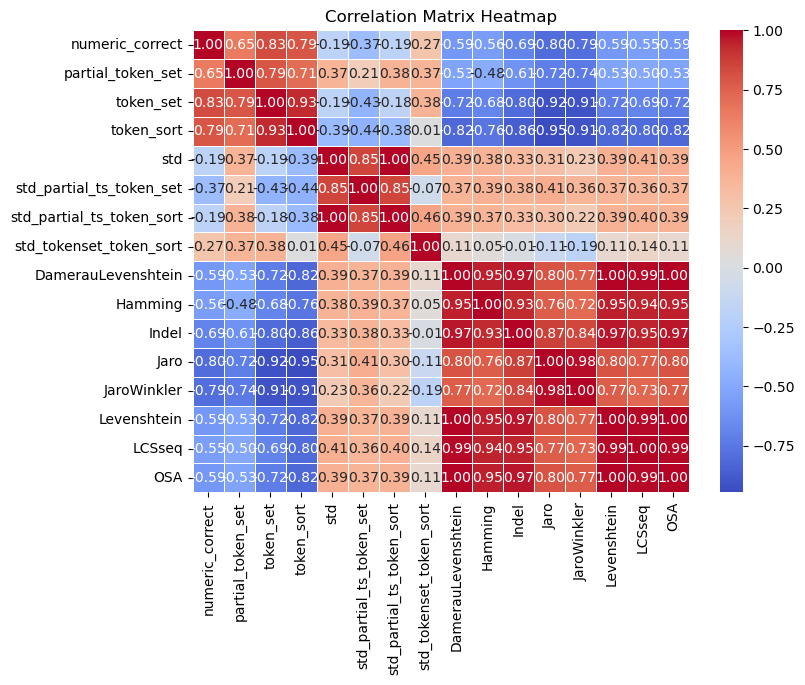

In [122]:
# Make a heatmap visualization of the correlation matrix (https://www.statology.org/how-to-calculate-visualize-correlation-matrices-pandas/)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

That's pretty hard to read, but it looks like there is a strong negative correlation (0.95) between Jaro distance and the `token_sort` ratio. Jaro distance also has a fairly strong negative correlation (0.80) to the `numeric_correct` value. That makes some sense, because Jaro distance is supposed to be "[well-suited for comparing short strings like names](https://distancia.readthedocs.io/en/latest/Jaro.html#introduction)." For all the distance metrics, a lower score indicates a stronger likelihood of a match. Since I set "yes" to a value higher than "no", I created an inverse relationship between the distance scores and the correctness score.

Let's get a less cluttered correlation, showing just the distance metrics and the numeric_correct columns.

In [123]:
distance_metrics = correct_yes_no[['numeric_correct','DamerauLevenshtein', 'Hamming', 'Indel', 'Jaro', 'JaroWinkler',
       'Levenshtein', 'LCSseq', 'OSA']]
distance_correlation_matrix = distance_metrics.corr()

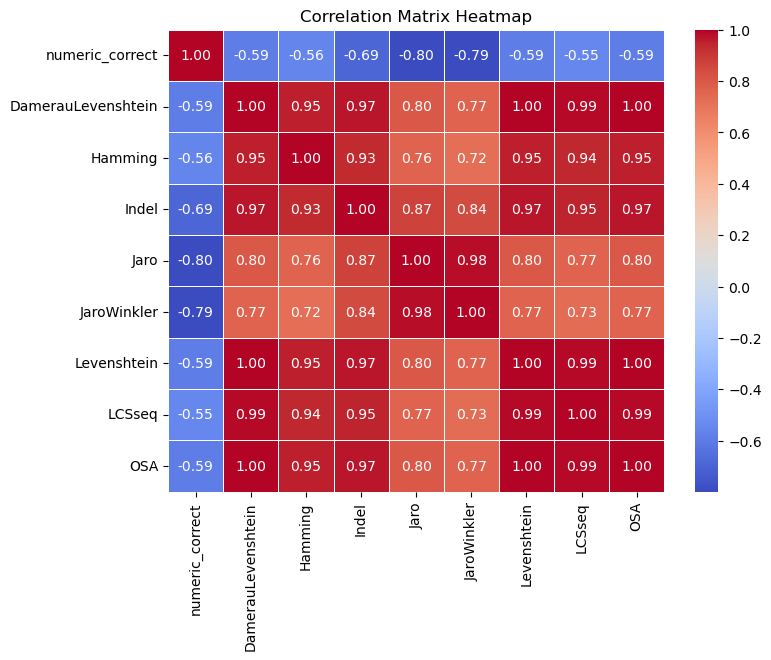

In [124]:
plt.figure(figsize=(8, 6))
sns.heatmap(distance_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

What happens when I filter out the authors in the `unmatched_authors_list` from the results of the DistilBERT matching?

In [191]:
import utilities
stripped_unmatched_authors_list = [utilities.normalize_author_name(name) for name in unmatched_authors_list]
filtered_df_no_deterministic = correct_yes_no[~correct_yes_no['stripped_author'].isin(stripped_unmatched_authors_list)]
print(f"Number of rows in the correct_yes_no dataframe: {len(correct_yes_no)}")
print(f"Number of rows in the filtered_df dataframe: {len(filtered_df_no_deterministic)}")

Number of rows in the correct_yes_no dataframe: 2119
Number of rows in the filtered_df dataframe: 650


Now let's remove the authors matched only by the fuzzy matching method.

In [220]:
filtered_df_no_deterministic_or_fuzzy = filtered_df_no_deterministic[~filtered_df_no_deterministic['stripped_author'].isin(fuzzy)]
print(f"Number of authors matched deterministically: {len(deterministically_matched_authors_list)}")
print(f"Number of authors matched only by fuzzy matching: {len(fuzzy_not_deterministic)}")
print(f"Number of unique authors matched only by DistilBERT: {(len(deterministically_matched_authors_list)+len(fuzzy_not_deterministic)-len(filtered_df_no_deterministic_or_fuzzy))}")

print(f"Total number of authors matched by all methods combined: {len(deterministically_matched_authors_list)+len(fuzzy_not_deterministic)+len(filtered_df_no_deterministic_or_fuzzy)}")
print(f"Total number of unique authors in the original data: {len(df['author'].unique())}")


Number of authors matched deterministically: 444
Number of authors matched only by fuzzy matching: 355
Number of unique authors matched only by DistilBERT: 149
Total number of authors matched by all methods combined: 1449
Total number of unique authors in the original data: 5556


Does that mean that the matching routines are a failure? Not at all. Many of the 5,556 authors are actually duplicates, with variant spellings.

I could have saved myself a lot of tedious work by filtering out those unmatched authors before tagging them as correct or not correct! 

Maybe?

Let's see how the correct values shake out.

In [129]:
filtered_df_no_deterministic_or_fuzzy['correct'].value_counts()

correct
yes      640
no         8
maybe      2
Name: count, dtype: int64

And how many correct values did that eliminate?

In [130]:
correct_yes_no['correct'].value_counts()

correct
no       1170
yes       938
maybe      11
Name: count, dtype: int64

It eliminated 298 correctly identified authors! That's a lot!

I wonder what would happen if I applied what I know about the inverse relationship with the Jaro distance metric?

In [176]:
jaro_correct = correct_yes_no[correct_yes_no['Jaro'] < 0.61]
jaro_correct['numeric_correct'].value_counts()

numeric_correct
0    1165
1     949
Name: count, dtype: int64

I kept changing the numbers until all 938 "yes" and "maybe" values were in the value_counts with Jaro < 0.61. Unfortunately, it captured nearly all of the "no" values, too, so there doesn't appear to be a magic number for getting just the "yes" values.

In [177]:
jaro_correct = correct_yes_no[correct_yes_no['Jaro'] < 0.20]
jaro_correct['numeric_correct'].value_counts()

numeric_correct
1    732
0      8
Name: count, dtype: int64

At Jaro < 0.20, there are 732 yes values and 8 no values. That's 77% of the total yes values, which isn't terrible, but it's not wonderful, either.

However, I could possibly put the Jaro distance metric to work earlier in the processing stages. Perhaps something like this:

>If the fuzzy matching function produces an authorized name that has a Jaro distance of less than 0.20 from the input author name, then pass it to the DistilBERT model for further matching.

Finally, before moving on to titles, I want to see how many of the rows in the original dataframe have been matched by any method.

In [221]:
distilbert_author_list = [author for author in filtered_df_no_deterministic_or_fuzzy['stripped_author'].unique()]

In [222]:
# Combine the lists
combined_match_list = deterministically_matched_authors_list + fuzzy_matched_authors_list + distilbert_author_list

In [223]:
original_authors_list = df['author'].to_list()
original_stripped_authors_list = [utilities.normalize_author_name(author) for author in original_authors_list]
original_stripped_authors_set = sorted(set(original_stripped_authors_list))
combined_match_set = sorted(set(combined_match_list))

4818
1189


In [225]:
difference = sorted(set(original_stripped_authors_list) ^ set(combined_match_list))
for author in difference:
    print(author)

abad diego jose 17271779
abadia de santillana del mar
abati baldo angelo
abaunza pedro de 15991649
abbatius baldus angelus 16th cent
abbeloos j b 18361896
abbeloos jean baptiste 18361906
abbo, monk of st. germain, approximately 850-approximately 923
abelard, peter
abicht rudolf 18501921
abrahams nicolai christian levin 17981870
abril pedro simon ca 1530 ca 1595
abu alfaraj alisbahani 897 or 8967
abu alfaraj alisbahani 897 or 898967
abu alrabi sulayman ibn abd allah almuwahhid
abu mihjan althaqafi active 629637
abu tammam habib ibn aws altai active 808842
abu tammam habib ibn aws altai fl 808842
abu ubayd alqasim ibn sallam approximately 773approximately 837
academia molshemensis francia
accademia degli occulti brescia
acevedo alfonso de 15181598
achillini alessandro
achillini alessandro 14631512
acidalius valens 15671595
ackermann johann christian gottlieb 17561801
ackermann petrus fouerius 17711831
aconcio iacopo 1566
acosta, josé de, 1540-1600
actuarius johannes
adam f 18351909
adam

## What about Titles?

This is where the automation really matters. If it can't handle titles accurately, it hasn't really saved much time, since titles take by far that longest amount of time to reconcile manually.

This is where the approach might need adjustment. Specifically, I need to consider using the DistilBERT matching score as the trigger for narrowing down the potential titles to be matched.

In [183]:
title_df = df[['author','title','deterministic_author','matched_title_deterministic', 'fuzzy_author','matched_title_fuzzy','fuzzy_title_score','distilbert_author']]

In [184]:
# How many titles were matched with the deterministic method?
deterministic_not_unknown = title_df[title_df['matched_title_deterministic'] != "Unknown"]
print(deterministic_not_unknown.info())
deterministic_not_unknown['matched_title_deterministic'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, 116 to 13411
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   author                       152 non-null    object 
 1   title                        152 non-null    object 
 2   deterministic_author         125 non-null    object 
 3   matched_title_deterministic  152 non-null    object 
 4   fuzzy_author                 135 non-null    object 
 5   matched_title_fuzzy          152 non-null    object 
 6   fuzzy_title_score            152 non-null    float64
 7   distilbert_author            152 non-null    object 
dtypes: float64(1), object(7)
memory usage: 10.7+ KB
None


matched_title_deterministic
orator            51
panegyricus       27
aeneis            17
apologia          10
cato               8
ibis               8
brutus             5
monarchia          5
germania           4
lepidina           2
atticus            2
scacchia           2
historia           1
antonius           1
proslogion         1
lucullus           1
rudens             1
aeneid             1
caligula           1
pharsalia          1
heptateuchos       1
utopia             1
anticlaudianus     1
Name: count, dtype: int64

In [185]:
# How many titles were matched with the fuzzy method?
fuzzy_not_unknown = title_df[title_df['matched_title_fuzzy'] != "Unknown"]
print(fuzzy_not_unknown.info())
fuzzy_not_unknown['matched_title_fuzzy'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 2379 entries, 27 to 13486
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   author                       2379 non-null   object 
 1   title                        2379 non-null   object 
 2   deterministic_author         1356 non-null   object 
 3   matched_title_deterministic  2379 non-null   object 
 4   fuzzy_author                 1575 non-null   object 
 5   matched_title_fuzzy          2379 non-null   object 
 6   fuzzy_title_score            2379 non-null   float64
 7   distilbert_author            2379 non-null   object 
dtypes: float64(1), object(7)
memory usage: 167.3+ KB
None


matched_title_fuzzy
ab urbe condita                                  129
de rerum natura                                  110
stephani abbatis epistola ad sanctum aunarium    108
singulae uoces ex incertis libris                 86
in p. clodium et c. curionem                      62
                                                ... 
de castitate seruanda carmen                       1
inscriptiones in basilica et in refectorio         1
nouum organum                                      1
de bello germanico (fragment)                      1
de incarnatione iesu christi domini nostri         1
Name: count, Length: 490, dtype: int64

In [186]:
unknown_titles = title_df[(title_df['matched_title_deterministic'] == "Unknown") & (title_df['matched_title_fuzzy'] == "Unknown")]
unknown_titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11040 entries, 0 to 13490
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   author                       11040 non-null  object 
 1   title                        11040 non-null  object 
 2   deterministic_author         2926 non-null   object 
 3   matched_title_deterministic  11040 non-null  object 
 4   fuzzy_author                 3682 non-null   object 
 5   matched_title_fuzzy          11040 non-null  object 
 6   fuzzy_title_score            11040 non-null  float64
 7   distilbert_author            11040 non-null  object 
dtypes: float64(1), object(7)
memory usage: 776.2+ KB


In [187]:
unknown_titles_known_authors = unknown_titles[~unknown_titles['author'].isin(unmatched_authors_list)]
unknown_titles_known_authors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3682 entries, 3 to 13488
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   author                       3682 non-null   object 
 1   title                        3682 non-null   object 
 2   deterministic_author         2926 non-null   object 
 3   matched_title_deterministic  3682 non-null   object 
 4   fuzzy_author                 3682 non-null   object 
 5   matched_title_fuzzy          3682 non-null   object 
 6   fuzzy_title_score            3682 non-null   float64
 7   distilbert_author            3682 non-null   object 
dtypes: float64(1), object(7)
memory usage: 258.9+ KB


I'm going to run these unknown titles with known authors through the process_metada function again (see `hybrid.ipynb`) with a different fuzzy matching algorithm.

In [188]:
unknown_titles_known_authors.to_csv('../data/unknown_title_known_authors-2.csv',index=False,quoting=csv.QUOTE_ALL,encoding='utf-8')